**Actividad - Autoencoder para detección de fraude**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score
)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

if '__file__' in globals():
    ruta_base = os.path.dirname(os.path.abspath(__file__))
else:
    ruta_base = os.getcwd()

ruta_datos = os.path.join(ruta_base, "..", "data", "application_train.csv")
datos = pd.read_csv(ruta_datos)

filas, columnas = datos.shape
tasa_incumplimiento = datos["TARGET"].mean() * 100
casos_normales = (datos["TARGET"] == 0).sum()
casos_incumplidos = (datos["TARGET"] == 1).sum()

print(f"\nArchivo cargado correctamente: {filas} filas y {columnas} columnas")
print(f"Tasa de incumplimiento: {tasa_incumplimiento:.2f}%")
print(f"Casos normales: {casos_normales} | Casos incumplidos: {casos_incumplidos}")




Archivo cargado correctamente: 307511 filas y 122 columnas
Tasa de incumplimiento: 8.07%
Casos normales: 282686 | Casos incumplidos: 24825


In [4]:
# Selección de variables y creación de nuevas características

# Variables de tiempo
datos['EDAD'] = -datos['DAYS_BIRTH'] / 365
datos['AÑOS_EMPLEADO'] = -datos['DAYS_EMPLOYED'] / 365
datos['AÑOS_EMPLEADO'] = datos['AÑOS_EMPLEADO'].replace(1000.67, np.nan)
datos['DIAS_CAMBIO_TELEFONO'] = -datos['DAYS_LAST_PHONE_CHANGE']
datos['DIAS_PUBLICACION_ID'] = -datos['DAYS_ID_PUBLISH']

# Ratios financieros
datos['RATIO_CREDITO_INGRESO'] = datos['AMT_CREDIT'] / datos['AMT_INCOME_TOTAL']
datos['RATIO_ANUALIDAD_INGRESO'] = datos['AMT_ANNUITY'] / datos['AMT_INCOME_TOTAL']
datos['RATIO_ANUALIDAD_CREDITO'] = datos['AMT_ANNUITY'] / datos['AMT_CREDIT']
datos['RATIO_BIENES_CREDITO'] = datos['AMT_GOODS_PRICE'] / datos['AMT_CREDIT']
datos['INGRESO_PER_CAPITA'] = datos['AMT_INCOME_TOTAL'] / (datos['CNT_FAM_MEMBERS'] + 1)
datos['CREDITO_PER_CAPITA'] = datos['AMT_CREDIT'] / (datos['CNT_FAM_MEMBERS'] + 1)

# Detección de inconsistencias
datos['INCONS_SCORE_INGRESO'] = 0
mask1 = (datos['EXT_SOURCE_2'] < 0.3) & (datos['AMT_INCOME_TOTAL'] > datos['AMT_INCOME_TOTAL'].quantile(0.75))
datos.loc[mask1, 'INCONS_SCORE_INGRESO'] = 1

datos['INCONS_FAMILIA_INGRESO'] = 0
mask2 = (datos['CNT_FAM_MEMBERS'] >= 4) & (datos['AMT_INCOME_TOTAL'] < datos['AMT_INCOME_TOTAL'].quantile(0.25))
datos.loc[mask2, 'INCONS_FAMILIA_INGRESO'] = 1

columnas_docs = [col for col in datos.columns if 'FLAG_DOCUMENT' in col]
datos['TOTAL_DOCUMENTOS'] = datos[columnas_docs].sum(axis=1)
datos['INCONS_DOCS_CREDITO'] = 0
mask3 = (datos['TOTAL_DOCUMENTOS'] <= 2) & (datos['AMT_CREDIT'] > datos['AMT_CREDIT'].quantile(0.75))
datos.loc[mask3, 'INCONS_DOCS_CREDITO'] = 1

datos['TOTAL_INCONSISTENCIAS'] = (datos['INCONS_SCORE_INGRESO'] + 
                                   datos['INCONS_FAMILIA_INGRESO'] + 
                                   datos['INCONS_DOCS_CREDITO'])

# Variables de círculo social
datos['DEFAULTS_SOCIALES'] = (datos['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(0) + 
                               datos['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(0))
datos['OBSERVACIONES_SOCIALES'] = (datos['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(0) + 
                                    datos['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(0))
datos['TASA_DEFAULT_SOCIAL'] = datos['DEFAULTS_SOCIALES'] / (datos['OBSERVACIONES_SOCIALES'] + 1)
datos['TIENE_CIRCULO_RIESGOSO'] = (datos['DEFAULTS_SOCIALES'] > 0).astype(int)

# Variables de estabilidad
datos['TIENE_AUTO'] = (~datos['OWN_CAR_AGE'].isna()).astype(int)
datos['TIENE_PROPIEDAD'] = (datos['FLAG_OWN_REALTY'] == 'Y').astype(int)
datos['CAMBIO_TELEFONO_RECIENTE'] = (datos['DIAS_CAMBIO_TELEFONO'] < 180).astype(int)
datos['PUBLICACION_ID_RECIENTE'] = (datos['DIAS_PUBLICACION_ID'] < 365).astype(int)

datos['SCORE_ESTABILIDAD'] = (datos['TIENE_AUTO'] + datos['TIENE_PROPIEDAD'] + 
                               (1 - datos['CAMBIO_TELEFONO_RECIENTE']) + 
                               (1 - datos['PUBLICACION_ID_RECIENTE']))

# Interacciones y flags de riesgo
datos['RATIO_EDAD_EMPLEO'] = datos['EDAD'] / (datos['AÑOS_EMPLEADO'] + 1)
datos['SOBREENDEUDAMIENTO'] = (datos['RATIO_CREDITO_INGRESO'] > 8).astype(int)
datos['JOVEN_CREDITO_ALTO'] = ((datos['EDAD'] < 25) & (datos['AMT_CREDIT'] > 500000)).astype(int)
datos['EMPLEO_NUEVO_CREDITO_ALTO'] = ((datos['AÑOS_EMPLEADO'] < 0.5) & (datos['AMT_CREDIT'] > 300000)).astype(int)

columnas_bureau = [col for col in datos.columns if 'AMT_REQ_CREDIT_BUREAU' in col]
datos['TOTAL_CONSULTAS_BUREAU'] = datos[columnas_bureau].sum(axis=1)
datos['CONSULTAS_EXCESIVAS'] = (datos['TOTAL_CONSULTAS_BUREAU'] > 5).astype(int)

# Lista de variables seleccionadas
variables_seleccionadas = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
    'RATIO_CREDITO_INGRESO', 'RATIO_ANUALIDAD_INGRESO', 'RATIO_ANUALIDAD_CREDITO',
    'INGRESO_PER_CAPITA', 'CREDITO_PER_CAPITA',
    'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'EDAD', 'AÑOS_EMPLEADO', 'DAYS_REGISTRATION', 'RATIO_EDAD_EMPLEO',
    'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'TASA_DEFAULT_SOCIAL', 'TIENE_CIRCULO_RIESGOSO',
    'REGION_RATING_CLIENT', 'REG_CITY_NOT_WORK_CITY',
    'TOTAL_DOCUMENTOS', 'SCORE_ESTABILIDAD',
    'TOTAL_INCONSISTENCIAS', 'INCONS_SCORE_INGRESO', 
    'INCONS_FAMILIA_INGRESO', 'INCONS_DOCS_CREDITO',
    'SOBREENDEUDAMIENTO', 'JOVEN_CREDITO_ALTO', 'EMPLEO_NUEVO_CREDITO_ALTO', 
    'CONSULTAS_EXCESIVAS', 'CAMBIO_TELEFONO_RECIENTE'
]

print(f"\nVariables creadas: {len(variables_seleccionadas)}")
print(f"Inconsistencias detectadas: {datos['TOTAL_INCONSISTENCIAS'].sum()}")


Variables creadas: 31
Inconsistencias detectadas: 89958


In [5]:
# PREPARACION DE DATOS

# Crear dataset de trabajo
datos_trabajo = datos[variables_seleccionadas + ['TARGET', 'SK_ID_CURR']].copy()

# Imputar valores nulos
for col in variables_seleccionadas:
    if datos_trabajo[col].isnull().sum() > 0:
        if col in ['EXT_SOURCE_2', 'EXT_SOURCE_3']:
            datos_trabajo[col].fillna(datos_trabajo[col].median(), inplace=True)
        else:
            datos_trabajo[col].fillna(0, inplace=True)

# Separar datos normales para entrenar el autoencoder
datos_normales = datos_trabajo[datos_trabajo['TARGET'] == 0].copy()
X_normales = datos_normales[variables_seleccionadas].values
X_todos = datos_trabajo[variables_seleccionadas].values
y_todos = datos_trabajo['TARGET'].values

# Dividir en entrenamiento y validacion
X_entrenamiento, X_validacion = train_test_split(X_normales, test_size=0.2, random_state=42)

# Escalar datos
escalador = RobustScaler()
X_entrenamiento_escalado = escalador.fit_transform(X_entrenamiento)
X_validacion_escalado = escalador.transform(X_validacion)
X_todos_escalado = escalador.transform(X_todos)

print(f"\nDatos preparados:")
print(f"Entrenamiento: {X_entrenamiento.shape}")
print(f"Validacion: {X_validacion.shape}")
print(f"Dataset completo: {X_todos.shape}")


Datos preparados:
Entrenamiento: (226148, 31)
Validacion: (56538, 31)
Dataset completo: (307511, 31)


In [6]:
# CONSTRUCCION Y ENTRENAMIENTO DEL AUTOENCODER

# Definir arquitectura del autoencoder
dimension_entrada = X_entrenamiento_escalado.shape[1]

# Capa de entrada
entrada = Input(shape=(dimension_entrada,))

# Encoder: comprime la informacion
x = Dense(128, activation='relu')(entrada)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Capa latente (representacion comprimida)
codigo = Dense(16, activation='relu')(x)

# Decoder: reconstruye la informacion
x = Dense(32, activation='relu')(codigo)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)

# Capa de salida
salida = Dense(dimension_entrada, activation='linear')(x)

# Crear y compilar el modelo
autoencoder = Model(entrada, salida)
autoencoder.compile(optimizer='adam', loss='mae', metrics=['mse'])

print(f"\nModelo creado con {dimension_entrada} variables de entrada")
autoencoder.summary()

# Configurar callbacks para el entrenamiento
parada_temprana = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reducir_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, verbose=1)

# Entrenar el modelo
print("\nEntrenando autoencoder...")
historial = autoencoder.fit(
    X_entrenamiento_escalado, X_entrenamiento_escalado,
    epochs=150,
    batch_size=256,
    validation_data=(X_validacion_escalado, X_validacion_escalado),
    callbacks=[parada_temprana, reducir_lr],
    verbose=1
)

print(f"\nEntrenamiento completado en {len(historial.history['loss'])} epocas")
print(f"Loss final entrenamiento: {historial.history['loss'][-1]:.4f}")
print(f"Loss final validacion: {historial.history['val_loss'][-1]:.4f}")


Modelo creado con 31 variables de entrada


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 31)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,727 (123.93 KB)

 Trainable params: 30,831 (120.43 KB)

 Non-trainable params: 896 (3.50 KB)


Entrenando autoencoder...
Epoch 1/150
884/884 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.0915 - mse: 78.0307 - val_loss: 0.3474 - val_mse: 1.3257 - learning_rate: 0.0010
Epoch 2/150
884/884 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4019 - mse: 1.7693 - val_loss: 0.3317 - val_mse: 1.1999 - learning_rate: 0.0010
Epoch 3/150
884/884 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3725 - mse: 1.2415 - val_loss: 0.2688 - val_mse: 0.3020 - learning_rate: 0.0010
Epoch 4/150
884/884 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3484 - mse: 1.0631 - val_loss: 0.2617 - val_mse: 0.3571 - learning_rate: 0.0010
Epoch 5/150
884/884 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3370 - mse: 1.0091 - val_loss: 0.2415 - val_mse: 0.2598 - learning_rate: 0.0010
Epoch 6/150
884/884 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3361 - mse: 0.9920 - val_loss: 0.2240 - val_mse: 0.2108 - learning_rate: 0.0010
Epoch 7/150
884/884 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3261 - mse: 0.8848 - val_loss: 0.2217 - val_mse: 0.

In [9]:
# DETECCION DE ANOMALIAS Y TOP 10 SOSPECHOSOS

# Calcular errores de reconstruccion
X_todos_reconstruido = autoencoder.predict(X_todos_escalado, verbose=0)
error_reconstruccion = np.mean(np.abs(X_todos_escalado - X_todos_reconstruido), axis=1)
datos_trabajo['ERROR_RECONSTRUCCION'] = error_reconstruccion

# Calcular errores por variable (solo para las variables seleccionadas)
errores_features = np.abs(X_todos_escalado - X_todos_reconstruido)
for i, feat in enumerate(variables_seleccionadas):
    datos_trabajo[f'ERROR_{feat}'] = errores_features[:, i]

# Optimizar threshold
thresholds = np.percentile(error_reconstruccion, range(85, 100, 1))
mejor_f1 = 0
mejor_threshold = 0

for thresh in thresholds:
    predicciones = (error_reconstruccion > thresh).astype(int)
    reporte = classification_report(y_todos, predicciones, output_dict=True, zero_division=0)
    f1 = reporte['1']['f1-score']
    if f1 > mejor_f1:
        mejor_f1 = f1
        mejor_threshold = thresh

# Clasificar anomalias
datos_trabajo['ANOMALIA'] = (error_reconstruccion > mejor_threshold).astype(int)

print(f"\nThreshold optimo: {mejor_threshold:.4f} (F1-score: {mejor_f1:.3f})")
print(f"Anomalias detectadas: {datos_trabajo['ANOMALIA'].sum():,} ({datos_trabajo['ANOMALIA'].mean()*100:.2f}%)")
print(f"\nReporte de clasificacion:")
print(classification_report(y_todos, datos_trabajo['ANOMALIA'], target_names=['Normal', 'Anomalia']))

puntaje_auc = roc_auc_score(y_todos, error_reconstruccion)
print(f"AUC Score: {puntaje_auc:.4f}")

# Analizar top 10 casos mas sospechosos
top_10 = datos_trabajo.nlargest(10, 'ERROR_RECONSTRUCCION').copy()

print("\n" + "="*100)
print("TOP 10 CASOS MAS SOSPECHOSOS")
print("="*100)

for idx, (i, fila) in enumerate(top_10.iterrows(), 1):
    print(f"\nCASO #{idx} - ID: {int(fila['SK_ID_CURR'])}")
    print(f"Error: {fila['ERROR_RECONSTRUCCION']:.4f} | TARGET: {'DEFAULT' if fila['TARGET']==1 else 'NORMAL'}")
    
    print(f"Perfil: Ingreso ${fila['AMT_INCOME_TOTAL']:,.0f}, Credito ${fila['AMT_CREDIT']:,.0f}, Ratio {fila['RATIO_CREDITO_INGRESO']:.2f}x")
    print(f"Edad {fila['EDAD']:.0f} años, {fila['AÑOS_EMPLEADO']:.1f} años empleo, {int(fila['CNT_FAM_MEMBERS'])} familiares")
    
    # Señales de alerta
    alertas = []
    if fila['SOBREENDEUDAMIENTO'] == 1:
        alertas.append("Sobreendeudamiento extremo")
    if fila['JOVEN_CREDITO_ALTO'] == 1:
        alertas.append("Joven con credito alto")
    if fila['EMPLEO_NUEVO_CREDITO_ALTO'] == 1:
        alertas.append("Empleo reciente + credito alto")
    if fila['TOTAL_INCONSISTENCIAS'] > 0:
        alertas.append(f"{int(fila['TOTAL_INCONSISTENCIAS'])} inconsistencias")
    if fila['TIENE_CIRCULO_RIESGOSO'] == 1:
        alertas.append("Circulo social riesgoso")
    if fila['CONSULTAS_EXCESIVAS'] == 1:
        alertas.append("Consultas bureau excesivas")
    if fila['SCORE_ESTABILIDAD'] < 2:
        alertas.append(f"Baja estabilidad ({int(fila['SCORE_ESTABILIDAD'])}/4)")
    
    if alertas:
        print(f"Alertas: {', '.join(alertas)}")
    
    # Top 3 variables mas anomalas (solo de las variables seleccionadas)
    errores_vars = {}
    for var in variables_seleccionadas:
        col_error = f'ERROR_{var}'
        if col_error in fila.index:
            errores_vars[var] = fila[col_error]
    
    top_3_errores = sorted(errores_vars.items(), key=lambda x: x[1], reverse=True)[:3]
    
    print("Variables mas anomalas:")
    for j, (nombre_feat, val_error) in enumerate(top_3_errores, 1):
        valor_actual = fila[nombre_feat]
        print(f"  {j}. {nombre_feat}: {valor_actual:.4f} (error: {val_error:.4f})")
    print("-" * 100)

# Resumen del top 10
print(f"\nRESUMEN TOP 10:")
print(f"Defaults reales: {int(top_10['TARGET'].sum())}/10")
print(f"Ratio credito/ingreso promedio: {top_10['RATIO_CREDITO_INGRESO'].mean():.2f}x")
print(f"Con inconsistencias: {(top_10['TOTAL_INCONSISTENCIAS'] > 0).sum()}/10")
print(f"Con circulo riesgoso: {int(top_10['TIENE_CIRCULO_RIESGOSO'].sum())}/10")

# Exportar resultados
top_10_exportar = top_10[[
    'SK_ID_CURR', 'ERROR_RECONSTRUCCION', 'TARGET', 'ANOMALIA',
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'RATIO_CREDITO_INGRESO',
    'EDAD', 'AÑOS_EMPLEADO', 'TOTAL_INCONSISTENCIAS',
    'SOBREENDEUDAMIENTO', 'TIENE_CIRCULO_RIESGOSO', 'SCORE_ESTABILIDAD'
]].copy()
top_10_exportar.to_csv('top_10_casos_sospechosos.csv', index=False)
print("\nExportado: top_10_casos_sospechosos.csv")


Threshold optimo: 0.2655 (F1-score: 0.155)
Anomalias detectadas: 46,127 (15.00%)

Reporte de clasificacion:
              precision    recall  f1-score   support

      Normal       0.93      0.86      0.89    282686
    Anomalia       0.12      0.22      0.15     24825

    accuracy                           0.80    307511
   macro avg       0.52      0.54      0.52    307511
weighted avg       0.86      0.80      0.83    307511

AUC Score: 0.5762

TOP 10 CASOS MAS SOSPECHOSOS

CASO #1 - ID: 114967
Error: 66.2605 | TARGET: DEFAULT
Perfil: Ingreso $117,000,000, Credito $562,491, Ratio 0.00x
Edad 35 años, 2.5 años empleo, 3 familiares
Alertas: 1 inconsistencias
Variables mas anomalas:
  1. AMT_INCOME_TOTAL: 117000000.0000 (error: 1136.8601)
  2. INGRESO_PER_CAPITA: 29250000.0000 (error: 655.9537)
  3. AÑOS_EMPLEADO: 2.5260 (error: 141.2451)
----------------------------------------------------------------------------------------------------

CASO #2 - ID: 336147
Error: 8.9613 | TARGET: 

In [11]:
# CALCULO DEL UMBRAL OPTIMO

# Calcular errores de reconstruccion
print("\nCalculando errores...")
X_reconstruido = autoencoder.predict(X_todos_escalado, verbose=0)
error_reconstruccion = np.mean(np.abs(X_todos_escalado - X_reconstruido), axis=1)
datos_trabajo['ERROR_RECONSTRUCCION'] = error_reconstruccion

# Buscar mejor umbral
print("Optimizando umbral...")
umbrales_posibles = np.percentile(error_reconstruccion, range(85, 100, 1))
mejor_f1 = 0
mejor_umbral = 0

for umbral in umbrales_posibles:
    predicciones = (error_reconstruccion > umbral).astype(int)
    reporte = classification_report(y_todos, predicciones, 
                                    output_dict=True, zero_division=0)
    f1_actual = reporte['1']['f1-score']
    
    if f1_actual > mejor_f1:
        mejor_f1 = f1_actual
        mejor_umbral = umbral

# Clasificar anomalias
datos_trabajo['ANOMALIA'] = (error_reconstruccion > mejor_umbral).astype(int)
anomalias_detectadas = datos_trabajo['ANOMALIA'].sum()
porcentaje_anomalias = datos_trabajo['ANOMALIA'].mean() * 100

print(f"\nUmbral optimo: {mejor_umbral:.4f}")
print(f"Anomalias: {anomalias_detectadas:,} ({porcentaje_anomalias:.2f}%)")
print(f"\nReporte:")
print(classification_report(y_todos, datos_trabajo['ANOMALIA'], 
                           target_names=['Normal', 'Anomalia']))

auc_puntaje = roc_auc_score(y_todos, error_reconstruccion)
print(f"AUC: {auc_puntaje:.4f}")


Calculando errores...
Optimizando umbral...

Umbral optimo: 0.2655
Anomalias: 46,127 (15.00%)

Reporte:
              precision    recall  f1-score   support

      Normal       0.93      0.86      0.89    282686
    Anomalia       0.12      0.22      0.15     24825

    accuracy                           0.80    307511
   macro avg       0.52      0.54      0.52    307511
weighted avg       0.86      0.80      0.83    307511

AUC: 0.5762


(0.0, 0.40550998729154375)

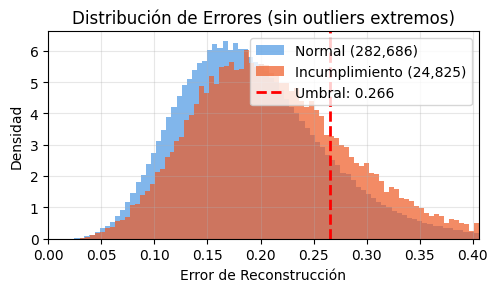

In [ ]:
# VISUALIZACIONES

# Separar errores por clase
errores_normales = datos_trabajo[datos_trabajo['TARGET'] == 0]['ERROR_RECONSTRUCCION']
errores_incumplidos = datos_trabajo[datos_trabajo['TARGET'] == 1]['ERROR_RECONSTRUCCION']

# Crear figura principal
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)

# Histograma de errores
ax1 = fig.add_subplot(gs[0, 0])
# Limitar rango para ver mejor la distribución
rango_max = np.percentile(error_reconstruccion, 99)
ax1.hist(errores_normales[errores_normales < rango_max], bins=80, alpha=0.6, 
         label=f'Normal ({len(errores_normales):,})', 
         color='#2E86DE', density=True)
ax1.hist(errores_incumplidos[errores_incumplidos < rango_max], bins=80, alpha=0.7, 
         label=f'Incumplimiento ({len(errores_incumplidos):,})', 
         color='#EE5A24', density=True)
ax1.axvline(mejor_umbral, color='red', linestyle='--', linewidth=2, 
            label=f'Umbral: {mejor_umbral:.3f}')
ax1.set_xlabel('Error de Reconstrucción')
ax1.set_ylabel('Densidad')
ax1.set_title('Distribución de Errores (sin outliers extremos)')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.set_xlim(0, rango_max)

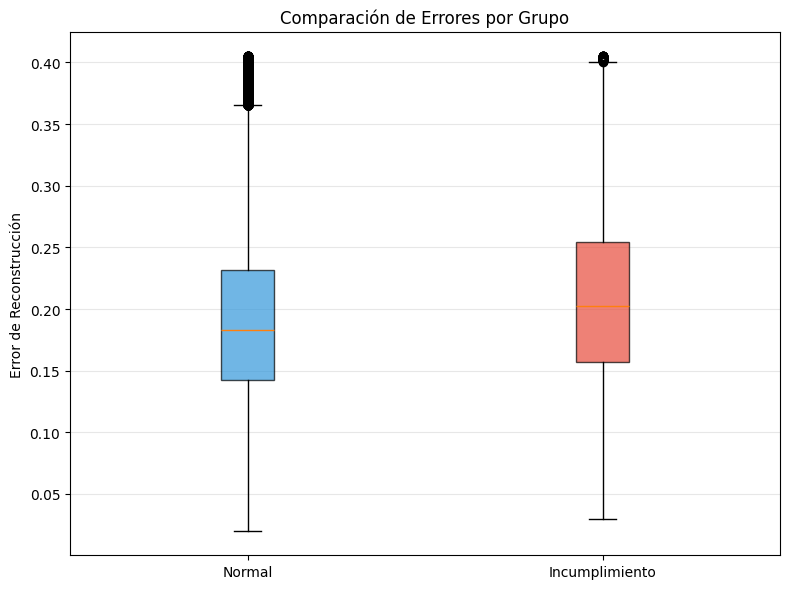

In [ ]:
# Boxplot comparativo

errores_norm_lim = errores_normales[errores_normales < rango_max]
errores_incump_lim = errores_incumplidos[errores_incumplidos < rango_max]

plt.figure(figsize=(8, 6))
cajas = plt.boxplot([errores_norm_lim, errores_incump_lim], 
                     labels=['Normal', 'Incumplimiento'], 
                     patch_artist=True)
cajas['boxes'][0].set_facecolor('#3498DB')
cajas['boxes'][1].set_facecolor('#E74C3C')
for caja in cajas['boxes']:
    caja.set_alpha(0.7)
plt.ylabel('Error de Reconstrucción')
plt.title('Comparación de Errores por Grupo')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('02_boxplot_comparacion.png', dpi=300, bbox_inches='tight')
plt.show()

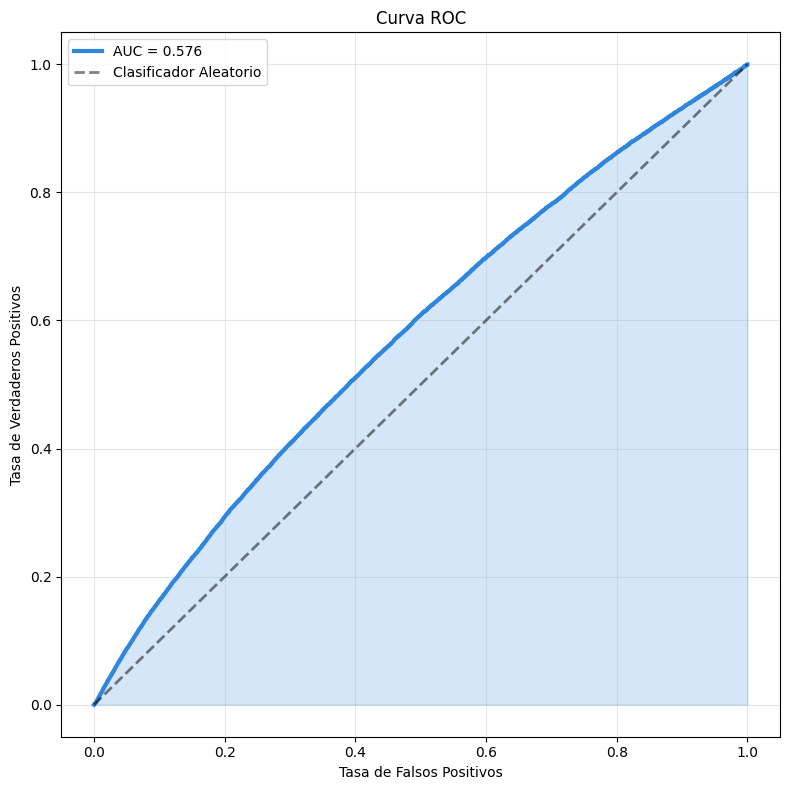

In [ ]:
# Curva ROC

fpr, tpr, _ = roc_curve(y_todos, error_reconstruccion)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linewidth=3, label=f'AUC = {auc_puntaje:.3f}', color='#2E86DE')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5, label='Clasificador Aleatorio')
plt.fill_between(fpr, tpr, alpha=0.2, color='#2E86DE')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('03_curva_roc.png', dpi=300, bbox_inches='tight')
plt.show()

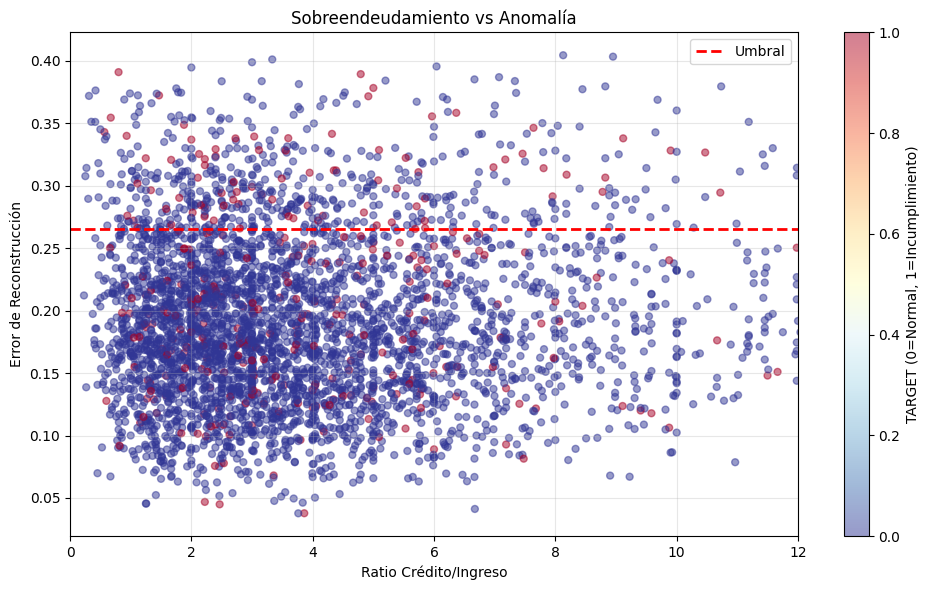

In [ ]:
# Ratio credito vs error

muestra = datos_trabajo.sample(n=min(4000, len(datos_trabajo)), random_state=42)
muestra_limpia = muestra[muestra['ERROR_RECONSTRUCCION'] < rango_max]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(muestra_limpia['RATIO_CREDITO_INGRESO'], 
                      muestra_limpia['ERROR_RECONSTRUCCION'],
                      c=muestra_limpia['TARGET'], cmap='RdYlBu_r', 
                      alpha=0.5, s=25)
plt.axhline(mejor_umbral, color='red', linestyle='--', linewidth=2, label='Umbral')
plt.xlabel('Ratio Crédito/Ingreso')
plt.ylabel('Error de Reconstrucción')
plt.title('Sobreendeudamiento vs Anomalía')
plt.xlim(0, 12)
plt.legend()
plt.colorbar(scatter, label='TARGET (0=Normal, 1=Incumplimiento)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('05_ratio_vs_error.png', dpi=300, bbox_inches='tight')
plt.show()

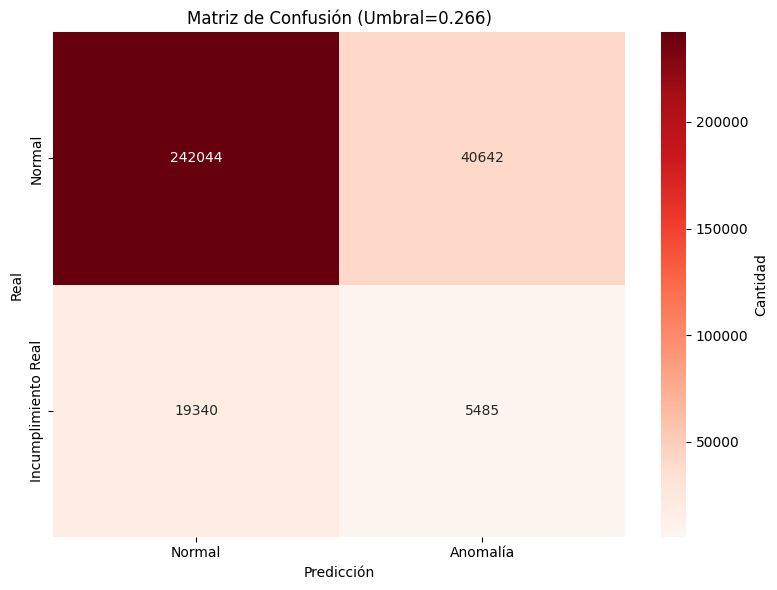

In [ ]:
# Matriz de confusion

matriz = confusion_matrix(y_todos, datos_trabajo['ANOMALIA'])

plt.figure(figsize=(8, 6))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Normal', 'Anomalía'],
            yticklabels=['Normal', 'Incumplimiento Real'],
            cbar_kws={'label': 'Cantidad'})
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión (Umbral={mejor_umbral:.3f})')
plt.tight_layout()
plt.savefig('06_matriz_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

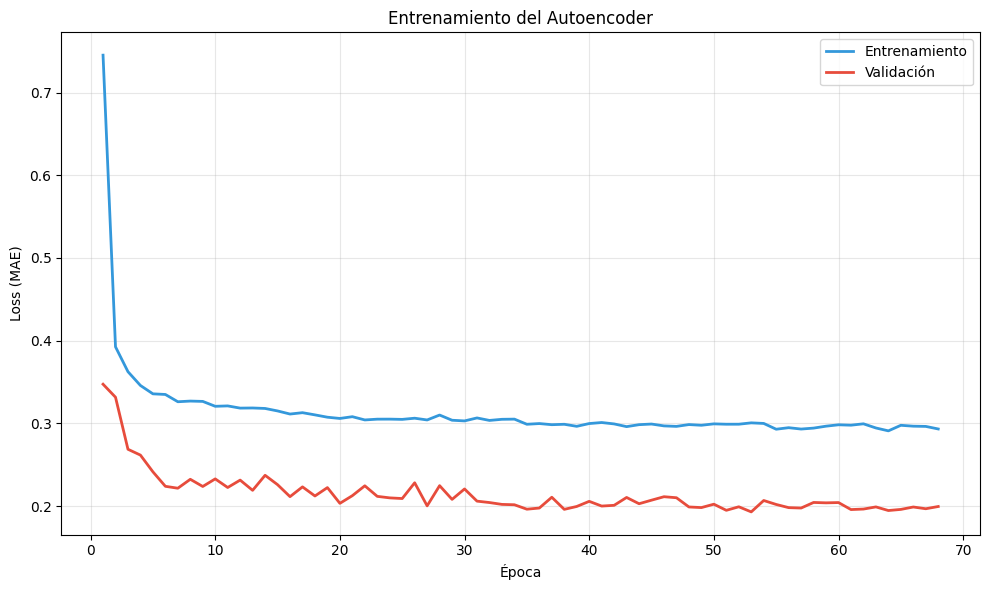

In [ ]:
# Curva de entrenamiento

epocas = range(1, len(historial.history['loss']) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epocas, historial.history['loss'], label='Entrenamiento', 
         linewidth=2, color='#3498DB')
plt.plot(epocas, historial.history['val_loss'], label='Validación', 
         linewidth=2, color='#E74C3C')
plt.xlabel('Época')
plt.ylabel('Loss (MAE)')
plt.title('Entrenamiento del Autoencoder')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('07_entrenamiento.png', dpi=300, bbox_inches='tight')
plt.show()

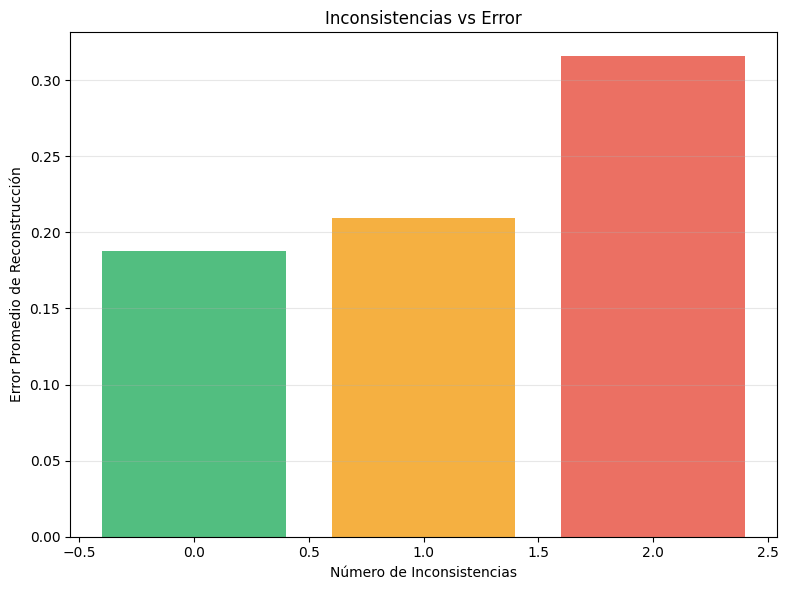

In [ ]:
# Inconsistencias vs error

grupos_incons = datos_trabajo.groupby('TOTAL_INCONSISTENCIAS')['ERROR_RECONSTRUCCION'].mean()

plt.figure(figsize=(8, 6))
barras = plt.bar(grupos_incons.index, grupos_incons.values, 
                 color=['#27AE60', '#F39C12', '#E74C3C', '#8E44AD'], alpha=0.8)
plt.xlabel('Número de Inconsistencias')
plt.ylabel('Error Promedio de Reconstrucción')
plt.title('Inconsistencias vs Error')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('08_inconsistencias.png', dpi=300, bbox_inches='tight')
plt.show()

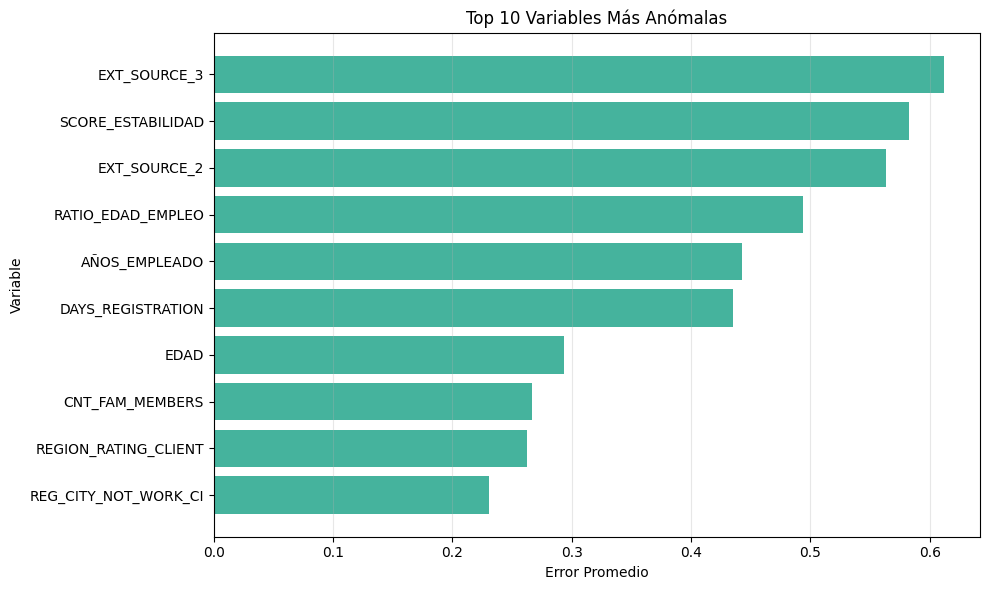

In [ ]:
# Top variables anomalas

errores_features = np.abs(X_todos_escalado - X_reconstruido)
importancia = {}
for i, var in enumerate(variables_seleccionadas):
    importancia[var] = errores_features[:, i].mean()

top_vars = sorted(importancia.items(), key=lambda x: x[1], reverse=True)[:10]
nombres_vars = [v[0][:20] for v in top_vars]
valores_vars = [v[1] for v in top_vars]

plt.figure(figsize=(10, 6))
plt.barh(nombres_vars, valores_vars, color='#16A085', alpha=0.8)
plt.xlabel('Error Promedio')
plt.ylabel('Variable')
plt.title('Top 10 Variables Más Anómalas')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('09_top_variables.png', dpi=300, bbox_inches='tight')
plt.show()

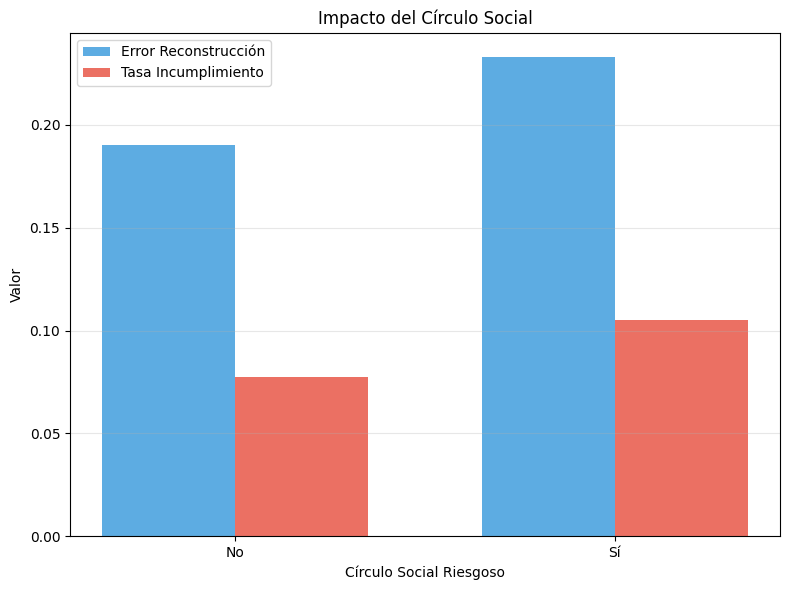

In [25]:
# Circulo social vs error

datos_social = datos_trabajo.groupby('TIENE_CIRCULO_RIESGOSO').agg({
    'ERROR_RECONSTRUCCION': 'mean',
    'TARGET': 'mean'
})

x_pos = np.arange(len(datos_social))
ancho = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x_pos - ancho/2, datos_social['ERROR_RECONSTRUCCION'], ancho, 
        label='Error Reconstrucción', color='#3498DB', alpha=0.8)
plt.bar(x_pos + ancho/2, datos_social['TARGET'], ancho, 
        label='Tasa Incumplimiento', color='#E74C3C', alpha=0.8)
plt.xlabel('Círculo Social Riesgoso')
plt.ylabel('Valor')
plt.title('Impacto del Círculo Social')
plt.xticks(x_pos, ['No', 'Sí'])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('10_circulo_social.png', dpi=300, bbox_inches='tight')
plt.show()

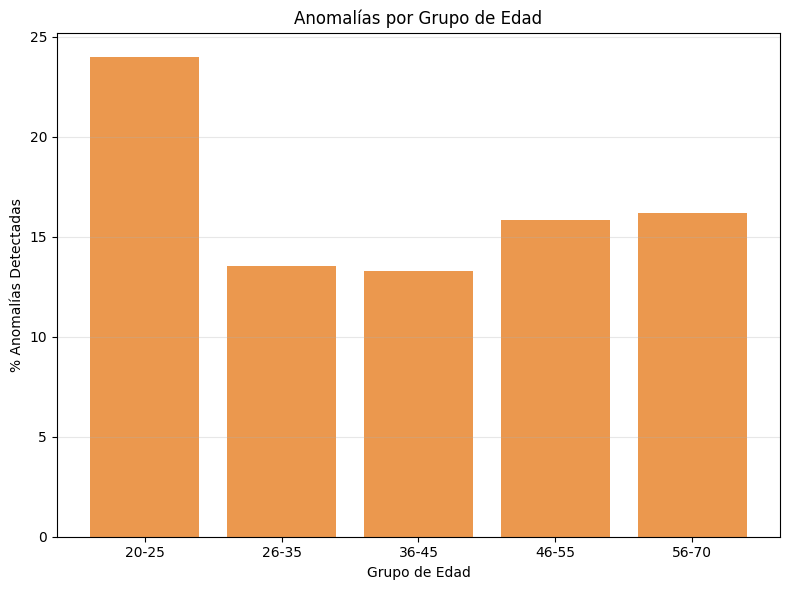

In [26]:
# Anomalias por edad

grupos_edad = pd.cut(datos_trabajo['EDAD'], 
                     bins=[20, 25, 35, 45, 55, 70], 
                     labels=['20-25', '26-35', '36-45', '46-55', '56-70'])
datos_trabajo['GRUPO_EDAD'] = grupos_edad
anomalias_edad = datos_trabajo.groupby('GRUPO_EDAD')['ANOMALIA'].mean() * 100

plt.figure(figsize=(8, 6))
plt.bar(range(len(anomalias_edad)), anomalias_edad.values, 
        color='#E67E22', alpha=0.8)
plt.xlabel('Grupo de Edad')
plt.ylabel('% Anomalías Detectadas')
plt.title('Anomalías por Grupo de Edad')
plt.xticks(range(len(anomalias_edad)), anomalias_edad.index)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('11_anomalias_edad.png', dpi=300, bbox_inches='tight')
plt.show()